In [18]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, unix_timestamp, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, to_date

In [19]:
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt


In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,  StringIndexer
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [22]:
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("predictconidtion").getOrCreate()


In [23]:
# Đọc dữ liệu từ file parquet
parquet_path = "/home/hoan123/project-master/delta_lake/delta_lake_table_3/"
df = spark.read.parquet(parquet_path)

In [24]:
# Sắp xếp dữ liệu theo cột datetime
df_sorted = df.orderBy("datetime")


In [25]:
condition_to_index = {
    "Cloudy": 0,
    "Light rain": 1,
    "Patchy rain possible": 2,
    "Moderate or heavy rain shower": 3,
    "Patchy light rain": 4,
    "Clear": 5,
    "Partly cloudy": 6,
    "Sunny": 7,
    "Patchy light drizzle": 8,
    "Light drizzle": 9,
    "Patchy light rain with thunder": 10,
    "Mist": 11,
    "Moderate rain at times": 12,
    "Thundery outbreaks possible": 13,
    "Moderate or heavy rain with thunder": 14,
    "Overcast": 15,
    "Moderate rain": 16,
    "Light rain shower": 17,
    "Heavy rain": 18,
    "Heavy rain at times": 19,
    "Fog": 20
}

# Bước 2: Hàm chuyển đổi chuỗi sang chỉ số
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def map_condition(condition):
    return condition_to_index.get(condition, -1)  # Trả về -1 nếu không tìm thấy giá trị phù hợp

map_condition_udf = udf(map_condition, IntegerType())

# Bước 3: Áp dụng UDF để tạo các cột condition đã mã hóa
df_sorted = df_sorted.withColumn("condition_index", map_condition_udf("condition"))

# Hiển thị kết quả
df_sorted.show()


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|2024-01-01 00:00:00|Hanoi|Vietnam| 21.0333|   105.85|  20.7|     5.8|    82.0|      0.0|       Partly cloudy|              6|
|2024-01-01 01:00:00|Hanoi|Vietnam| 21.0333|   105.85|  20.4|     6.0|    84.0|      0.0|              Cloudy|              0|
|2024-01-01 02:00:00|Hanoi|Vietnam| 21.0333|   105.85|  20.0|     4.9|    85.0|      0.0|              Cloudy|              0|
|2024-01-01 03:00:00|Hanoi|Vietnam| 21.0333|   105.85|  19.8|     4.5|    86.0|      0.0|            Overcast|             15|
|2024-01-01 04:00:00|Hanoi|Vietnam| 21.0333|   105.85|  19.6|     4.7|    87.0|      0.0|            Overcast| 

In [27]:

window = Window.orderBy("datetime")

# Thêm các cột feature từ các bước thời gian trước
df_with_lags = (
    df_sorted
    .withColumn("temp_c_t-1", lag("temp_c", 1).over(window))
    .withColumn("temp_c_t-2", lag("temp_c", 2).over(window))
    .withColumn("temp_c_t-3", lag("temp_c", 3).over(window))
    .withColumn("temp_c_t-4", lag("temp_c", 4).over(window))
    .withColumn("humidity_t-1", lag("humidity", 1).over(window))
    .withColumn("humidity_t-2", lag("humidity", 2).over(window))
    .withColumn("humidity_t-3", lag("humidity", 3).over(window))
    .withColumn("humidity_t-4", lag("humidity", 4).over(window))
    .withColumn("wind_mph_t-1", lag("wind_mph", 1).over(window))
    .withColumn("wind_mph_t-2", lag("wind_mph", 2).over(window))
    .withColumn("wind_mph_t-3", lag("wind_mph", 3).over(window))
    .withColumn("wind_mph_t-4", lag("wind_mph", 4).over(window))
    .withColumn("precip_mm_t-1", lag("precip_mm", 1).over(window))
    .withColumn("precip_mm_t-2", lag("precip_mm", 2).over(window))
    .withColumn("precip_mm_t-3", lag("precip_mm", 3).over(window))
    .withColumn("precip_mm_t-4", lag("precip_mm", 4).over(window))
    .withColumn("condition_t-1", lag("condition_index", 1).over(window))
    .withColumn("condition_t-2", lag("condition_index", 2).over(window))
    .withColumn("condition_t-3", lag("condition_index", 3).over(window))
    .withColumn("condition_t-4", lag("condition_index", 4).over(window))
    .withColumn("hour", hour("datetime"))
    .withColumn("day_of_month", dayofmonth("datetime"))
    .withColumn("day_of_week", dayofweek("datetime"))
    .withColumn("month", month("datetime"))
    .withColumn("quarter", quarter("datetime"))
    .withColumn("week", weekofyear("datetime"))
)

# Chọn các cột cần thiết và đổi tên cột label
df_final = df_with_lags.select(
    "datetime", 
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2", "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2","wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week", 
    "temp_c"  # Nhiệt độ hiện tại làm nhãn
).withColumnRenamed("temp_c", "label")

# Bỏ các hàng không đủ dữ liệu
df_final = df_final.na.drop()


In [28]:


# Thêm cột 'date' để lọc train-test
df_final = df_final.withColumn("date", to_date("datetime"))

# Chia dữ liệu train-test
train_data = df_final.filter(col("date") < "2024-10-30").drop("date")
test_data = df_final.filter(col("date") >= "2024-10-30").drop("date")

# Tạo feature vector
feature_cols = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2",  "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data).select("features", "label", "datetime")
test_data = assembler.transform(test_data).select("features", "label", "datetime")


In [29]:
# Tạo mô hình Random Forest Regression
rf = RandomForestRegressor(featuresCol="features", labelCol="label", maxDepth=5, numTrees=50)

# Train model
rf_model = rf.fit(train_data)

# Dự đoán trên tập test
predictions = rf_model.transform(test_data)


24/12/10 14:26:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

In [30]:
# Đánh giá mô hình
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")


24/12/10 14:26:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

Root Mean Squared Error (RMSE) on test data = 0.8999591916810309


24/12/10 14:26:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


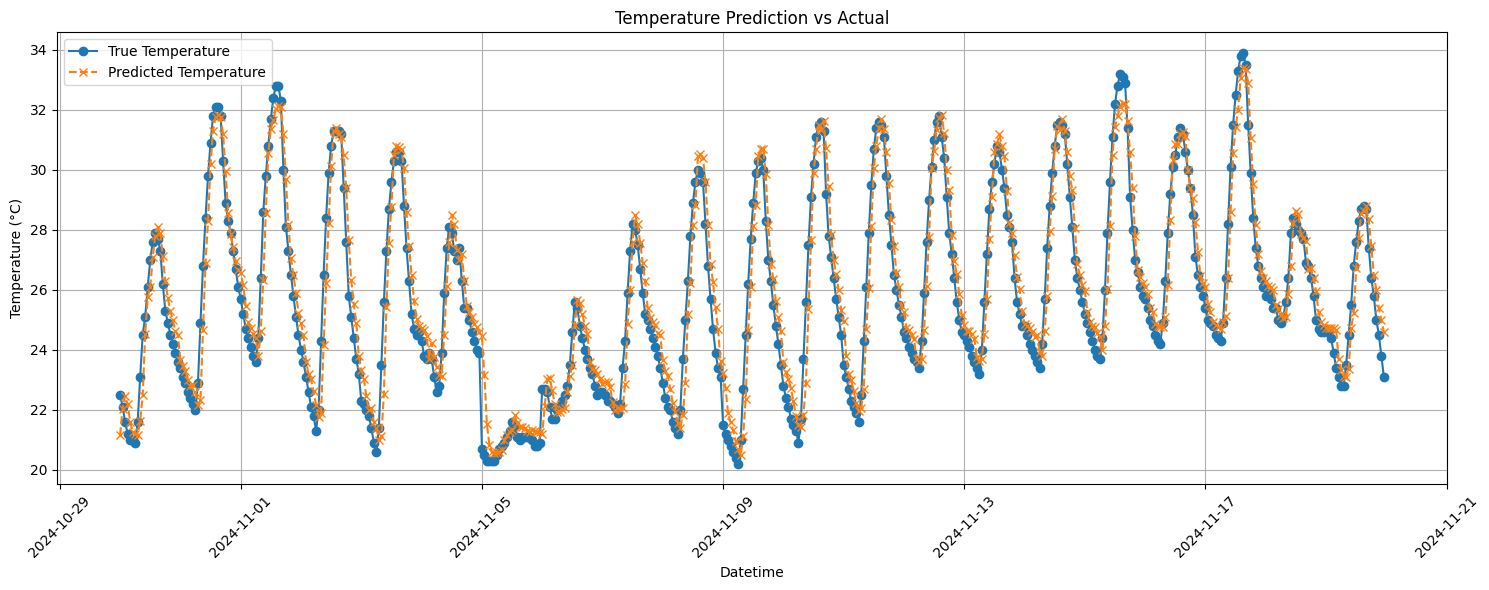

In [31]:
# Thu thập dữ liệu để vẽ biểu đồ
results = predictions.select("datetime", "label", "prediction").orderBy("datetime").toPandas()

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(results["datetime"], results["label"], label="True Temperature", marker='o', linestyle='-')
plt.plot(results["datetime"], results["prediction"], label="Predicted Temperature", marker='x', linestyle='--')
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
# Số bước thời gian muốn dự đoán
n_steps = 5

# Chuyển đổi test_data thành Pandas DataFrame để dễ xử lý trong vòng lặp
test_df = test_data.toPandas()

# Khởi tạo danh sách chứa kết quả
results = test_df.copy()
results["prediction"] = None

# Lặp để dự đoán nhiều bước
for step in range(n_steps):
    print(f"Predicting step {step + 1}...")

    # Nếu là bước đầu tiên, sử dụng dữ liệu thực từ test_df
    if step == 0:
        current_features = test_df[feature_cols]
    else:
        # Tạo các feature từ kết quả dự đoán trước đó
        for lag in range(1, 5):  # Cập nhật các cột temp_c_t-i
            results[f"temp_c_t-{lag}"] = results["prediction"].shift(lag)
        
        current_features = results[feature_cols]

    # Chuyển đổi thành DataFrame Spark
    current_features_spark = spark.createDataFrame(current_features)

    # Tạo feature vector
    current_features_spark = assembler.transform(current_features_spark)

    # Dự đoán bước thời gian hiện tại
    predictions = rf_model.transform(current_features_spark)

    # Lấy giá trị dự đoán và cập nhật vào kết quả
    predicted_values = predictions.select("prediction").toPandas()["prediction"]
    results.loc[:, "prediction"] = predicted_values

# Chỉ giữ các cột cần thiết để vẽ biểu đồ
final_results = results[["datetime", "label", "prediction"]]


24/12/10 14:26:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 14:26:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

Predicting step 1...


KeyError: "None of [Index(['temp_c_t-1', 'temp_c_t-2', 'temp_c_t-3', 'temp_c_t-4', 'humidity_t-1',\n       'humidity_t-2', 'humidity_t-3', 'humidity_t-4', 'wind_mph_t-1',\n       'wind_mph_t-2', 'wind_mph_t-3', 'wind_mph_t-4', 'precip_mm_t-1',\n       'precip_mm_t-2', 'precip_mm_t-3', 'precip_mm_t-4', 'condition_t-1',\n       'condition_t-2', 'condition_t-3', 'condition_t-4', 'hour',\n       'day_of_month', 'day_of_week', 'month', 'quarter', 'week'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
plt.plot(final_results["datetime"], final_results["label"], label="True Temperature", marker='o', linestyle='-')
plt.plot(final_results["datetime"], final_results["prediction"], label="Predicted Temperature", marker='x', linestyle='--')
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title(f"Temperature Prediction over {n_steps} Steps")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
